# LinearUCB

In this lecture we will implement the linear UCB algorithma and then we test it in a simple influence maximization problem.

We will see in which contents it's convenient this approach and then we will implement a basic environment in which the reward can be approximated by a linear combination of features vector and a coefficient vector.
And then we will implement and test the linearUCB algorithm.

In real problem the arms space is really huge (ex 9 million of edges) and we can't observe all edges in a reasonable amount of time.

So when the arms space is huge we can exploit the information gained on a subset observed arms to estimate the reward function of non-observed arms.

In this case we assume a linear generalization model in which

-Each arm $j$ is associated with a feature vector $x_j=(x_{j1},x_{j2},x_{j3},...,x_{jD})$ with $x_{ji}\in [0,1]$
(1 if the nodes share a feature, 0 if not)

-The reward is a linear combination of the arm feature vector and a parameter vector $\theta$:
    $r_t=x_t^T \theta$

In our problem the parameter vector $\theta$ is not given and it is exploited with observation on nodes activation

In [1]:
import numpy as np


class LinearMabEnvironment():
    def __init__(self, n_arms, dim): 
        self.theta = np.random.dirichlet(np.ones(dim), size = 1)  
        self.arms_features = np.random.binomial(1, 0.5, size=(n_arms, dim)) 
        self.p = np.zeros(n_arms)
        for i in range(0,n_arms):
            self.p[i] = np.dot(self.theta, self.arms_features[i]) 
            
    def round(self, pulled_arm):
        return 1 if np.random.random() < self.p[pulled_arm] else 0 
    
    def opt(self):
        return np.max(self.p) 

# Algorithm Linear UCB

Input: arms set A, parameter c>0 <br/>
Inizialization: $B_0=0 \in R^d,M_0=I \in R^{dxd}$ <br/>
For $t = 1,2,..,n$ do <br/>
&nbsp;&nbsp;&nbsp; 1) $\theta_{t-1}=M_{t-1}^{-1}B_{t-1}$ <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $UCBs=x^T\theta_{t-1}+c\sqrt{x^TM_{t-1}^{-1}x}$ <br/>
&nbsp;&nbsp;&nbsp; 2) Choose the arm with maximum ucb value <br/>
&nbsp;&nbsp;&nbsp; 3) Update matrices:<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) $M_t=M_{t-1}$   $B_t=B_{t-1}$ <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) $M_t=M_t+x_tx_t^T$ <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; and $B_t=B_t + x_tr_t$ <br/>

In [2]:
class LinUcbLearner():
    def __init__(self, arms_features):
        self.arms = arms_features
        self.dim = arms_features.shape[1] 
        self.collected_rewards = [] 
        self.pulled_arms = [] 
        self.c = 2.0 
        self.M = np.identity(self.dim) 
        self.b = np.atleast_2d(np.zeros(self.dim)).T 
        self.theta = np.dot(np.linalg.inv(self.M), self.b) 
        
        
    def compute_ucbs(self): 
        self.theta = np.dot(np.linalg.inv(self.M), self.b) 
        ucbs = [] 
        for arm in self.arms: 
            arm = np.atleast_2d(arm).T 
            ucb = np.dot(self.theta.T, arm) + self.c * np.sqrt(np.dot(arm.T, np.dot(np.linalg.inv(self.M), arm))) #1.2
            ucbs.append(ucb[0][0])
        return ucbs 

    def pull_arm(self):
        ucbs = self.compute_ucbs() 
        return np.argmax(ucbs)

    def update_estimation(self, arm_idx, reward):
        arm = np.atleast_2d(self.arms[arm_idx]).T 
        self.M += np.dot(arm, arm.T)
        self.b += reward * arm  
        
    def update (self, arm_idx, reward):
        self.pulled_arms.append(arm_idx) 
        self.collected_rewards.append(reward) 
        self.update_estimation (arm_idx, reward)

100%|██████████| 1000/1000 [00:02<00:00, 400.73it/s]


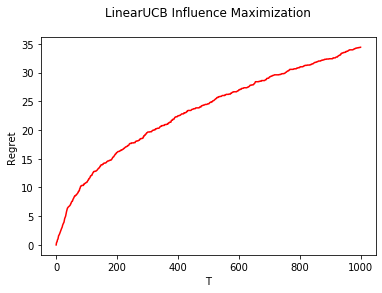

In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm

n_arms = 100 
T = 1000
n_experiments = 20
lin_ucb_rewards_per_experiment = []

env = LinearMabEnvironment (n_arms=n_arms, dim=4)

for e in range (0,n_experiments):
    lin_ucb_learner = LinUcbLearner(arms_features=env.arms_features) 
    for t in tqdm(range(0,T)):
        pulled_arm = lin_ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        lin_ucb_learner.update(pulled_arm, reward)
        
    lin_ucb_rewards_per_experiment.append(lin_ucb_learner.collected_rewards)
    

opt = env.opt() 

plt.figure(0) 
plt.title("LinearUCB Influence Maximization\n")
plt.ylabel("Regret") 
plt.xlabel("T") 
plt.plot(np.cumsum(np.mean(opt - lin_ucb_rewards_per_experiment, axis=0)), 'r') 
plt.plot(opt, 'g')
plt.savefig("linearUCB-regret-{}n-{}T.png".format(n_arms,T), dpi=200)
plt.show()

The Regret increases logaritmically as steps increase <br/>
Compare this with TS in the same settings